<a href="https://colab.research.google.com/github/DmytroTym/urban/blob/master/Elections_digitalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Діджиталізація результатів виборів

## Постановка задачі

Це пост про місцеві вибори в Києві, які [пройшли](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D1%81%D1%86%D0%B5%D0%B2%D1%96_%D0%B2%D0%B8%D0%B1%D0%BE%D1%80%D0%B8_%D0%B2_%D0%9A%D0%B8%D1%94%D0%B2%D1%96_2020) в один тур 25 жовтня 2020 року. Я пишу цей пост в кінці січня 2021, але краще пізно, ніж ніколи. Офіційні результати виборів можна знайти на [сайті ЦВК](https://www.cvk.gov.ua/pls/vm2020/pvm057pid112=30pid102=2pf7691=2pt001f01=695rej=0pt00_t001f01=695.html). Проблема в тому, що в кращому разі можна знайти [результати](https://kmr.gov.ua/uk/content/postanova-no-protokol-pro-rezultaty-vyboriv) по округах (які в основному співпадають з районами міста). Це унеможливлює серйозний аналіз і пошук аномалій зокрема; для цього потрібні результати по окремим дільницям (на дільниці зазвичай зареєстровані декілька тисяч виборців).

На щастя, команда народного депутата Романа Грищука [виклала](https://www.facebook.com/romagrishchuk/posts/1498622463655302) на [гугл-диск](http://bit.ly/SolomaVote) заповнені бланки з результатами на всіх дільницях Солом'янського району. Щоправда, це скани пдф-ок з заповненими від руки кількостями голосів. Оцифровкою цих бланків я й займуся в даному ноутбуці. Посилання на аналіз результатів з'явиться тут щойно я його закінчу.

### Приклад бланків

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r "/content/gdrive/My Drive/Солома_Паралельний_підрахунок.zip" ./

!unzip -qq /content/Солома_Паралельний_підрахунок.zip

In [ ]:
!pip -qq install pdf2image

!apt-get -qq update
!apt-get -qq install poppler-utils

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path, pdfinfo_from_path

plt.rcParams['figure.dpi'] = 280

In [9]:
example_path = '/content/Солома. Паралельний п_драхунок/800835-п.pdf'
example = convert_from_path(example_path, dpi=200, first_page=1, last_page=2)

Отже, титул бланка з дільниці $800835$:

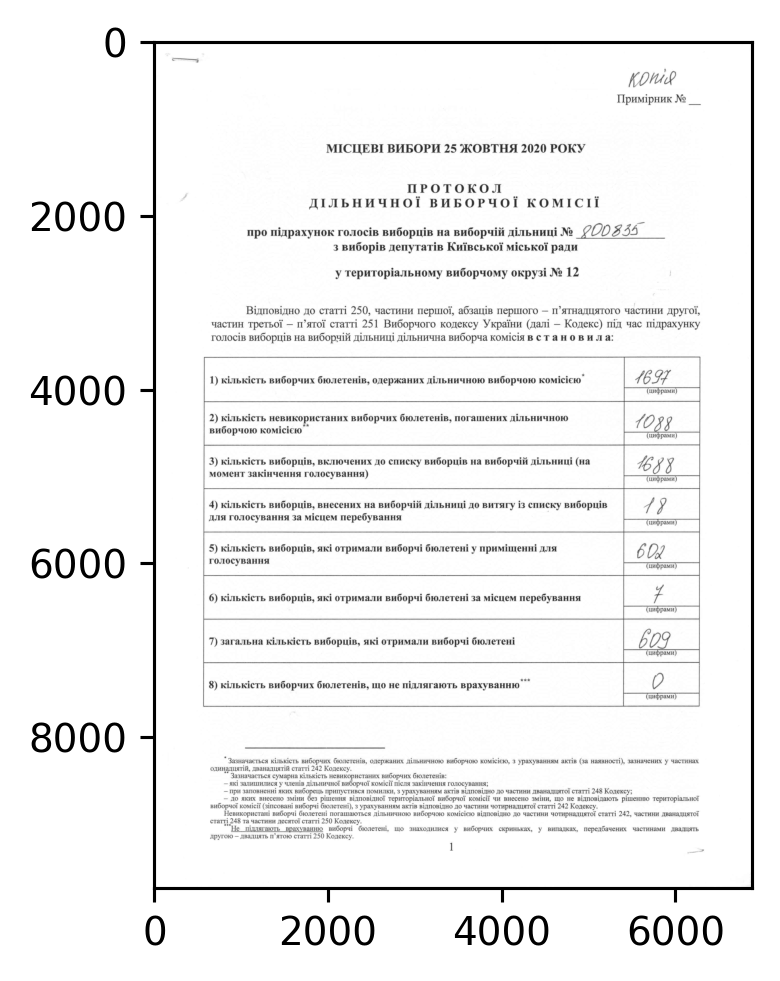

In [22]:
plt.imshow(cv2.cvtColor(np.array(example[0]), cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

Такий самий (або майже ідентичний) формат мають всі титульні листи. Ще один, другий, лист з цього бланка:

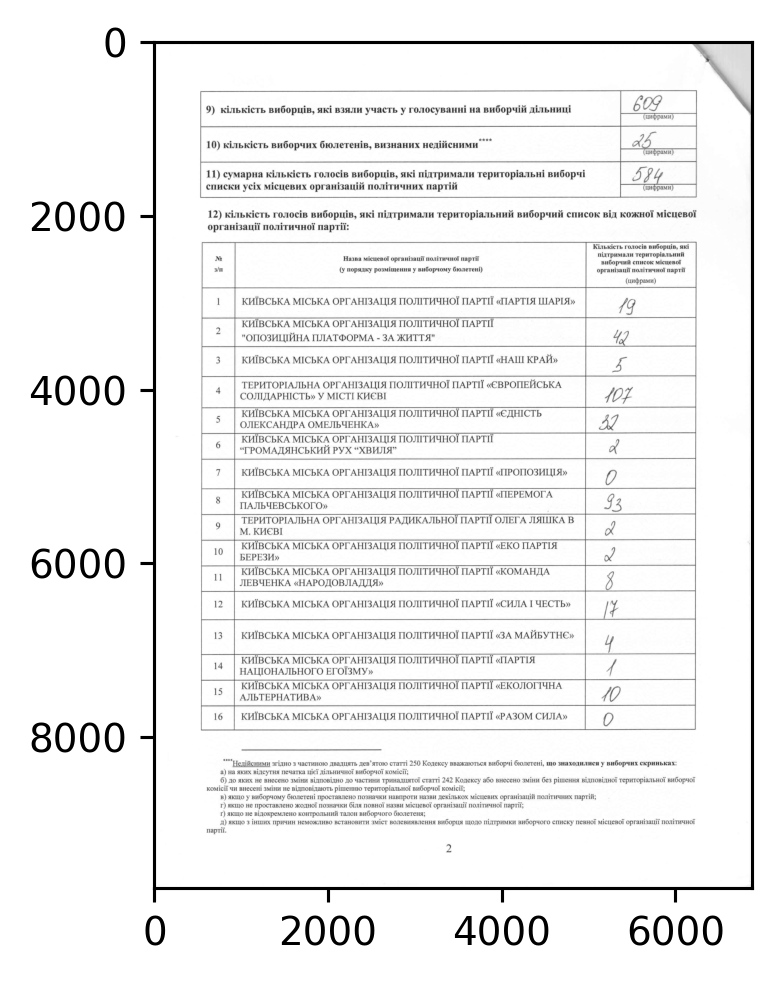

In [23]:
plt.imshow(cv2.cvtColor(np.array(example[1]), cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

## Машинне навчання для розпізнавання рукописних чисел

Як видно з прикладів бланків, всі результати внесені від руки. Правильно конвертувати їх у числа виявляється не так вже й просто. Принаймні, стандартні інструменти типу tesseract чи openocr з цим не справляються. Доведеться вчити свою модель.

### Датасет

Датасет - це рукописні числа від 0 до 999 включно. Одноцифрові числа представлені [MNIST'ом](https://en.wikipedia.org/wiki/MNIST_database), двох- і трьохцифрові - конкатенаціями представників MNIST'а, їх я взяв [звідси](https://github.com/andrehochuli/digitstringrecognition/tree/master/datasets). Датасет було попередньо розділено на $80\%$ трейну та $20\%$ тесту.

In [24]:
!cp -r "/content/gdrive/My Drive/mnist_png.zip" ./

!unzip -qq /content/mnist_png.zip

Приклад синтетичного троьхцифрового числа з датасету:

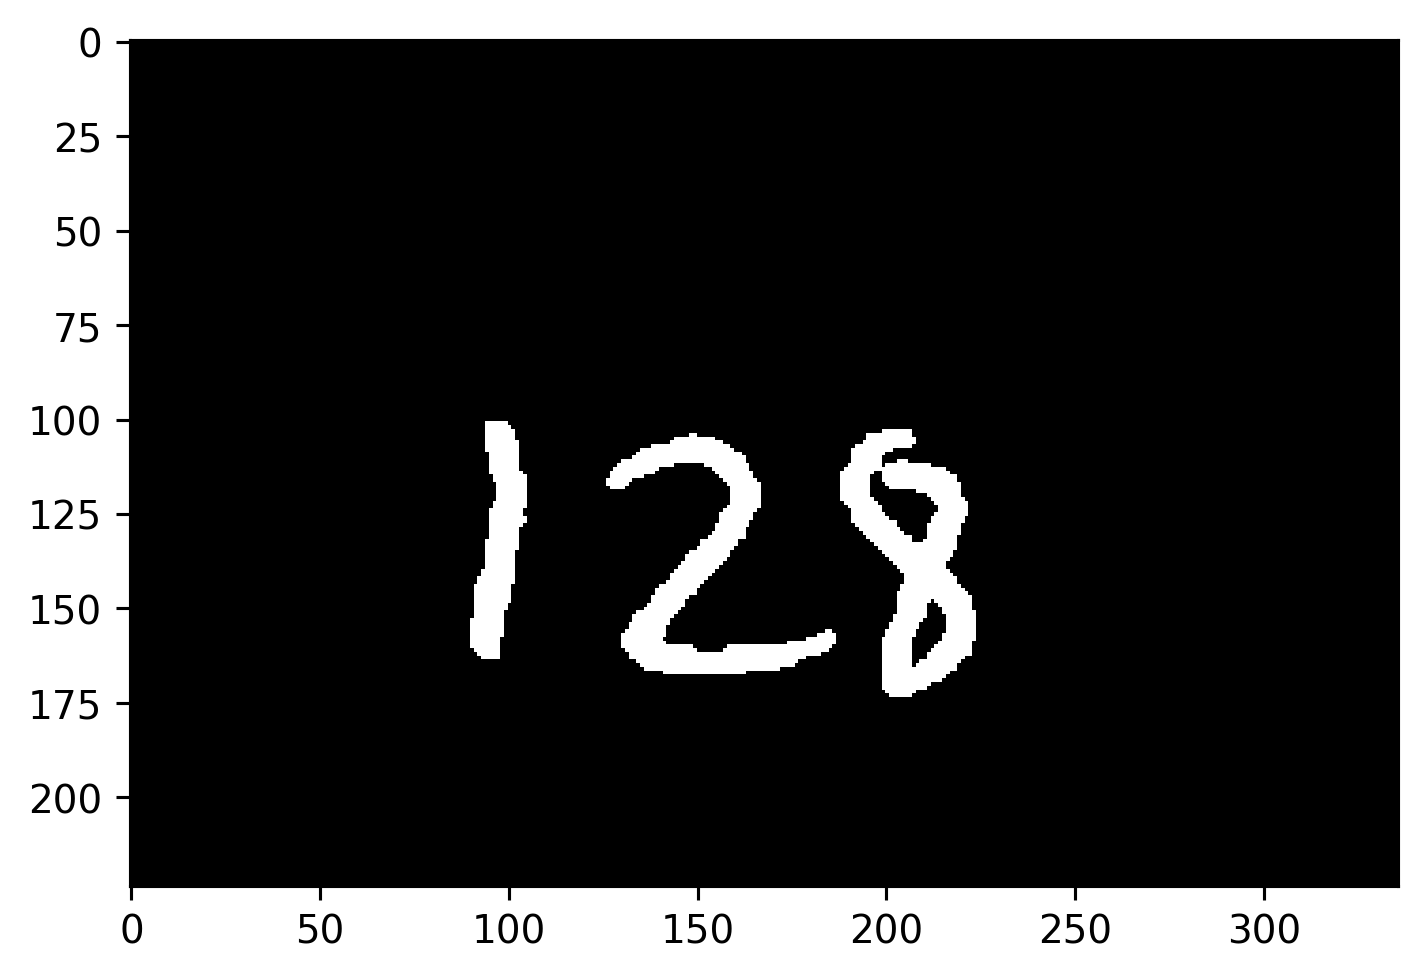

In [39]:
plt.imshow(cv2.imread('/content/mnist_png/testing/128/cdf3875_35_11.png'),
           cmap='gray')
plt.show()

In [34]:
from torchvision import transforms, datasets
import os

data_transforms = {
    'training': transforms.Compose([transforms.ToTensor()]),
    'testing': transforms.Compose([transforms.ToTensor()]),
}

data_dir = '/content/mnist_png'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) \
                  for x in ['training', 'testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) \
               for x in ['training', 'testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
train_class_names = image_datasets['training'].classes

### Модель

За основу я візьму ResNet - модель, що використовується зокрема для класифікації зображень:

In [26]:
import torch

import torchvision.models as models

In [27]:
# на етапі навчання я починав з pretrained моделі, тепер це непотрібно
resnet18 = models.resnet18(pretrained=False)

Архітектура виглядає так:

In [28]:
from torchsummary import summary

summary(resnet18, (3, 224, 336), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 168]           9,408
       BatchNorm2d-2         [-1, 64, 112, 168]             128
              ReLU-3         [-1, 64, 112, 168]               0
         MaxPool2d-4           [-1, 64, 56, 84]               0
            Conv2d-5           [-1, 64, 56, 84]          36,864
       BatchNorm2d-6           [-1, 64, 56, 84]             128
              ReLU-7           [-1, 64, 56, 84]               0
            Conv2d-8           [-1, 64, 56, 84]          36,864
       BatchNorm2d-9           [-1, 64, 56, 84]             128
             ReLU-10           [-1, 64, 56, 84]               0
       BasicBlock-11           [-1, 64, 56, 84]               0
           Conv2d-12           [-1, 64, 56, 84]          36,864
      BatchNorm2d-13           [-1, 64, 56, 84]             128
             ReLU-14           [-1, 64,

Ідея в тому, щоб замінити останні два шари - пулінг та лінійний шар. Пулінг "зклеює" горизонтальну і вертикальну інформацію, яку до цього шару закодувала мережа. Замінимо пулінг на лише "вертикальний", тобто такий, що робить усереднення лише по вертикальній координаті, лишаючи при цьому горизонтальну координату, яка дає важливу інформацію про розташвання цифр (адже вони завжди розташовуються зліва направо). Останній же лінійний шар так само буде діяти по каналам, але вже з 11-вимірним вектором на виході. Це ймовірності того, що у відповідній горизонтальній частині зображення немає жодної цифри або є яка-небудь цифра від 0 до 9. Таким чином матимемо вектор ймовірностей для кожної горизонтальної координати. Під час навчання пропускатимемо цей вектор через CTC loss.

In [29]:
import torch.nn as nn

class MyPooling(nn.Module):
    def __init__(self, *args):
        super(MyPooling, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.mean(x, dim=-2, keepdim=False)

class Transpose1(nn.Module):
    def __init__(self, *args):
        super(Transpose1, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.reshape(x, (-1, 512, 11)).permute(0, 2, 1)

class Transpose2(nn.Module):
    def __init__(self, *args):
        super(Transpose2, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.reshape(x, (-1, 11, 11)).permute(1, 0, 2)

resnet18.avgpool = MyPooling()
resnet18.fc = torch.nn.Sequential(Transpose1(),
                                  torch.nn.Linear(in_features=512,
                                                  out_features=11),
                                  torch.nn.LogSoftmax(dim=-1),
                                  Transpose2())


Далі йдуть методи для навчання і тестування моделі.

In [31]:
import time
import copy

def check_correct(predictions, target, label_length):
    predictions = np.array([torch.max(predictions.cpu()[i, :, :], 1)[1].numpy()
                            for i in range(11)])
    corrects = 0

    for i in range(predictions.shape[1]):
        ith_predictions = predictions[:, i]
        ith_target = target[sum(label_length[:i]):sum(label_length[:i+1])]
        prev_pixel, normal_preds = 0, []

        for pixel_prediction in ith_predictions:
            if pixel_prediction != 0 and pixel_prediction != prev_pixel:
                normal_preds.append(pixel_prediction)
            prev_pixel = pixel_prediction

        if tuple(normal_preds) == tuple(ith_target):
            corrects += 1

    return corrects


def infer(model, image):
    probs = model(torch.unsqueeze(image, 0))
    predictions = np.array([torch.max(probs.cpu()[i, :, :], 1)[1].numpy()
                        for i in range(11)])
    prev_pixel, normal_preds = 0, []

    for pixel_prediction in predictions:
        if pixel_prediction != 0 and pixel_prediction != prev_pixel:
            normal_preds.append(pixel_prediction)
        prev_pixel = pixel_prediction

    return normal_preds


def test_model(model):
    last_time = time.time()

    model.eval()

    running_corrects = 0
    
    for j, (inputs, labels) in enumerate(dataloaders['testing']):
        labels = [image_datasets['testing'].classes[label]
                  for label in labels]
        inputs = inputs.cuda()
        outputs = model(inputs)

        input_lengths = torch.full(size=(len(labels),),
                                   fill_value=11, dtype=torch.long)
        target_lengths = torch.tensor([len(str(label)) \
                                      for label in labels])
        labels = torch.tensor([int(x) + 1 for label in labels
                                for x in label])

        running_corrects += check_correct(outputs, labels, target_lengths)

    acc = running_corrects / dataset_sizes['testing']

    print('Accuracy on test {:.4f} Time {:.0f} seconds'.
          format(acc, time.time() - last_time))


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        last_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['training', 'testing']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for j, (inputs, labels) in enumerate(dataloaders[phase]):
                labels = [image_datasets[phase].classes[label]
                          for label in labels]
                inputs = inputs.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    input_lengths = torch.full(size=(len(labels),),
                                               fill_value=11, dtype=torch.long)
                    target_lengths = torch.tensor([len(str(label)) \
                                                  for label in labels])
                    labels = torch.tensor([int(x) + 1 for label in labels
                                           for x in label])
                    loss = criterion(outputs, labels, input_lengths, target_lengths)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += check_correct(outputs, labels, target_lengths)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Accuracy {:.4f} Time {:.0f} seconds'.format(
                phase, epoch_loss, epoch_acc, time.time() - last_time))

            # deep copy the model
            if phase == 'testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# тут закоментований код для навчання моделі

# ctc_loss = torch.nn.CTCLoss(reduction='mean')

# # Observe that all parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft = train_model(resnet18, ctc_loss, optimizer_ft,
#                        exp_lr_scheduler, num_epochs=25)

Не будемо нічого вчити, просто завантажимо словник з параметрами, які модель вже вивчила:

In [30]:
resnet18.load_state_dict(torch.load("/content/gdrive/My Drive/colab_models"))

<All keys matched successfully>

In [ ]:
resnet18.cuda()

In [ ]:
test_model(resnet18)

Точність розпізнвання на тесті досягає $99.2\%$. Я не очікую такої самої точності на реальних даних з ряду причин, але "доучування" мережі буде здійснюватись по ходу виправлення помилок. На щастя, їх можна буде виправляти без перегляду всіх класифікацій мережі завдяки тому, що в бланках є "зайва" інформація, яка слугуватиме для мене чексумами.

## Отримання клітинок з бланків

Перед тим, як розпізавати числа, потрібно виділити їх з бланків. Ця робота вже зроблена (значною мірою базуючись на [цьому пості на towardsdatascience](https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec)) і протестована, але ще не причепурена. Бланки подекуди сфотографовані, подекуди зіскановані, якість може бути дуже різною, але все ж завдяки однаковому шаблону і табличній структурі, бланки виходить оцифрувати досить добре. 

## Власне оцифровка

Єдина ще не зроблена частина. Оцифровка з перевіркою чексум, ручним виправленням помилок і паралельним доучуванням мережі має відбутись найбличим часом. Результати будуть викладені у відкритий доступ.

Далі йде хаотичний код:

In [ ]:
!pip install pdf2image

In [ ]:
import cv2
import numpy as np
import os
import json
import imutils
import matplotlib.pyplot as plt
from pdf2image import convert_from_path, pdfinfo_from_path
plt.rcParams['figure.dpi'] = 200

In [ ]:
# приведення всіх зображень до однієї висоти в 2500 пікселів
def scale_img(page_as_image, height=2500):
    width = int(page_as_image.shape[1] * (height / page_as_image.shape[0]))
    dim = (width, height)
    return cv2.resize(page_as_image, dim, interpolation = cv2.INTER_AREA)

low_threshold = 150
high_threshold = 255

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

def rotate_image(page_as_image):
    edges = cv2.Canny(page_as_image, low_threshold, high_threshold)

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
        
    angles = np.degrees([np.arctan((line[0][0]-line[0][2])/(line[0][1]-line[0][3]))
                        for line in lines])
    angles = [angle for angle in angles if abs(angle) < 45]
    if len(angles) > 0:
        page_as_image = imutils.rotate(page_as_image, -np.median(angles))
        page_as_image[:40,:] = 255
        page_as_image[-40:,:] = 255
        page_as_image[:,:40] = 255
        page_as_image[:,-40:] = 255

    return page_as_image

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_table(page_as_image, mode="binary_thresh"):
    img_bin = cv2.bitwise_not(page_as_image)
    # plt.imshow(page_as_image, cmap='gray')
    # plt.show()

    # Length(width) of kernel as 100th of total width
    kernel_len = np.array(page_as_image).shape[1]//100
    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

    #Use horizontal kernel to detect the horizontal lines
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    # plt.imshow(img_vh, cmap='gray')
    # plt.show()
    if mode == "binary_thresh":
      thresh, img_vh = cv2.threshold(img_vh, 225, 255, cv2.THRESH_BINARY)
    else:
      img_vh = cv2.adaptiveThreshold(img_vh, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 5)
    # plt.imshow(img_vh, cmap='gray')
    # plt.show()

    table_edges = cv2.Canny(img_vh, 50, high_threshold)
    table_lines = cv2.HoughLinesP(table_edges, rho, theta, 3, np.array([]),
                                  min_line_length, 50)
    for line in table_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_vh,(x1,y1),(x2,y2),0,2)

    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    #Get mean of heights
    mean = np.mean(heights)

    #Create list box to store all boxes in  
    boxes = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        xs, ys = [c_[0][0] for c_ in c], [c_[0][1] for c_ in c]
        if max(xs) - min(xs) > 10 and max(ys) - min(ys) > 10:
            x, y, w, h = cv2.boundingRect(c)
            if h < 200:
                boxes.append([x,y,w,h])
          
    return boxes

In [ ]:
def reconstruct_table(boxes):               
  def find_boxes(x, y, w, h, corner, tolerance = 10):
    res_list = []
    for box in boxes:
      if (w is None or abs(w - box[2]) < tolerance) and (h is None or abs(h - box[3]) < tolerance):
        if corner == 'top-left':
          if abs(x - box[0]) < tolerance and abs(y - box[1]) < tolerance:
            res_list.append(box)
        if corner == 'top-right':
          if abs(x - box[0] - box[2]) < tolerance and abs(y - box[1]) < tolerance:
            res_list.append(box)
        if corner == 'bottom-left':
          if abs(x - box[0]) < tolerance and abs(y - box[1] - box[3]) < tolerance:
            res_list.append(box)
        if corner == 'bottom-right':
          if abs(x - box[0] - box[2]) < tolerance and abs(y - box[1] - box[3]) < tolerance:
            res_list.append(box)
    return res_list

  appended_boxes = 0
  while True:
    all_boxes_added = True
    for box1 in boxes:
      for box2 in find_boxes(box1[0], box1[1], None, box1[3], corner='top-right'):
        for box3 in find_boxes(box1[0], box1[1] + box1[3], box1[2], None, corner='top-left'):
          if len(find_boxes(box1[0], box3[1], box2[2], box3[3], corner='top-right')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
        for box3 in find_boxes(box1[0], box1[1], box1[2], None, corner='bottom-left'):
          if len(find_boxes(box1[0], box1[1], box2[2], box3[3], corner='bottom-right')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
      for box2 in find_boxes(box1[0] + box1[2], box1[1], None, box1[3], corner='top-left'):
        for box3 in find_boxes(box1[0], box1[1] + box1[3], box1[2], None, corner='top-left'):
          if len(find_boxes(box2[0], box3[1], box2[2], box3[3], corner='top-left')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
        for box3 in find_boxes(box1[0], box1[1], box1[2], None, corner='bottom-left'):
          if len(find_boxes(box2[0], box3[1] + box3[3], box2[2], box3[3], corner='bottom-left')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
    if all_boxes_added:
      return

def process_image(page_as_image, cell_widths, cell_ratios):
  page_as_image = rotate_image(scale_img(page_as_image))
  boxes = get_table(page_as_image) + get_table(page_as_image, mode='other')
  reconstruct_table(boxes)
  boxes.sort(key=lambda x: x[1])
  added_boxes = []

  def is_box_not_added(b):
    for other_box in added_boxes:
      if other_box[1] < b[1] + 15 and other_box[1] + other_box[3] > b[1] + b[3] - 15:
        return False
    return True

  def get_good_boxes():
    image = None
    img = np.ones(page_as_image.shape) * 255
    for b in boxes:
      # print(b)
      for cell_width, cell_ratio in zip(cell_widths, cell_ratios):
        if abs(b[2] - cell_width) < 30 and is_box_not_added(b) and \
        (cell_ratio is None or abs(b[2] / b[3] - cell_ratio) < 0.4):
          image = cv2.rectangle(img,(b[0],b[1]),(b[0]+b[2],b[1]+b[3]),0,6)
          added_boxes.append(b)
          yield page_as_image[b[1] + 2:b[1] + b[3] - 2, b[0] + 2:b[0] + b[2] - 2]
        else:
          image = cv2.rectangle(img,(b[0],b[1]),(b[0]+b[2],b[1]+b[3]),0,2)
    # plt.imshow(image)
    # plt.show()

  good_boxes = list(get_good_boxes())
  med = np.median([gb[0] for gb in added_boxes])
  return [gb for i, gb in enumerate(good_boxes) if abs(added_boxes[i][0] - med) < 15]

In [ ]:
def split_by_local_minima(x_coord_list):
    if len(x_coord_list) < 50:
        return []
    for i in reversed(range(min(x_coord_list) + 4, max(x_coord_list) - 4)):
        if all([len([1 for x in x_coord_list if x == i - j]) < 10 for j in range(-1, 2)]):
            return split_by_local_minima([x for x in x_coord_list if x < i]) + \
        split_by_local_minima([x for x in x_coord_list if x > i])
    return [x_coord_list]

def resize_28_28(img_to_resize):
    if img_to_resize.shape[0] > img_to_resize.shape[1]:
        diff = img_to_resize.shape[0] - img_to_resize.shape[1]
        square_image = np.hstack((255 * np.ones((img_to_resize.shape[0], diff // 2)), img_to_resize,
                                 255 * np.ones((img_to_resize.shape[0], diff // 2 + diff % 2))))
        return cv2.resize(square_image, (28, 28), interpolation = cv2.INTER_AREA)
    else:
        diff = img_to_resize.shape[1] - img_to_resize.shape[0]
        square_image = np.vstack((255 * np.ones((diff // 2, img_to_resize.shape[1])), img_to_resize,
                                 255 * np.ones((diff // 2 + diff % 2, img_to_resize.shape[1]))))
        return cv2.resize(square_image, (28, 28), interpolation = cv2.INTER_AREA)

def digits_segmentation(digits_img):
    plt.imshow(digits_img, cmap = 'gray')
    plt.show()
    cY, cX = digits_img.shape[:2]
    digits_img = cv2.fastNlMeansDenoising(digits_img, h=15, templateWindowSize=7, searchWindowSize=21)
    best_angle, num_of_digits, num_of_pixels, cumulative_dist = 0, 0, 0, 0 

    for rotation_angle in range(-20, 21, 5):
        M = cv2.getRotationMatrix2D((cX // 2, cY // 2), rotation_angle, 1.0)
        rotated_img = cv2.warpAffine(digits_img, M, (cX, int(cY * 1.5)), borderValue=(255,255,255))
        black_pixels_x_coords = np.where(rotated_img < 250)[1]
        clusters = [(min(l), max(l)) for l in split_by_local_minima(black_pixels_x_coords)]

        if (len(clusters) > num_of_digits and len(clusters) < 5):
            number_of_digits = len(clusters)
            best_angle = (rotation_angle, list(clusters))
            cumulative_dist = sum([clusters[i + 1][0] - cluster[1] for i, cluster in enumerate(clusters[:-1])])
            num_of_pixels = len([1 for x in black_pixels_x_coords if x >= clusters[0][0] and x <= clusters[-1][1]])
        elif (len(clusters) == num_of_digits):
            cum_dist = sum([clusters[i + 1][0] - cluster[1] for i, cluser in enumerate(clusters[:-1])])
            num_of_pix = len([1 for x in black_pixels_x_coords if x >= clusters[0][0] and x <= clusters[-1][1]])
            if num_of_digits > 1 and cum_dist > cumulative_dist:
                best_angle = (rotation_angle, list(clusters))
                cumulative_dist = cum_dist
            if num_of_digits == 1 and num_of_pixels < num_of_pix:
                best_angle = (rotation_angle, list(clusters))
                num_of_pixels = num_of_pix

    M = cv2.getRotationMatrix2D((cX // 2, cY // 2), best_angle[0], 1.0)
    rotated_img = cv2.warpAffine(digits_img, M, (cX, int(cY * 1.5)), borderValue=(255,255,255))

    for limits in best_angle[1]:
        y_coords = np.where(rotated_img[:, limits[0]:limits[1]] < 200)[0]
        if len(y_coords) > 0 and limits[1] - limits[0] > 2:
            rotated_one_digit = rotated_img[min(y_coords) - 4:max(y_coords) + 4, limits[0]:limits[1]]
            d = rotated_one_digit.shape[1] // 5
            rotated_one_digit = np.hstack((255 * np.ones((rotated_one_digit.shape[0], d)), rotated_one_digit,
                                          255 * np.ones((rotated_one_digit.shape[0], d))))
            M_inv = cv2.getRotationMatrix2D((rotated_one_digit.shape[1] // 2, rotated_one_digit.shape[0] // 2),
                                            -best_angle[0], 1.0)
            try:
                one_digit = cv2.warpAffine(rotated_one_digit, M_inv,
                                          (rotated_one_digit.shape[1], rotated_one_digit.shape[0]),
                                          borderValue=(255,255,255))
                _, one_digit_binary = cv2.threshold(resize_28_28(one_digit),230,255,cv2.THRESH_BINARY_INV)
                # plt.imshow(one_digit_binary, 'gray')
                # plt.show()
                # print('Label is', get_label(one_digit_binary))
                yield one_digit_binary
            except:
                print('Error, shape:', rotated_one_digit.shape)

In [ ]:
general_cells = {1: 8, 2: 3}
general_cell_width = 202
general_cell_ratio = 202 / 76
general_alternative_cell_width = 209
general_alternative_cell_ratio = 209 / 59
parties_cells = {2: 16, 3: 8}
parties_all_cells = {3: 15, 4: 9}
parties_cell_width = 333
parties_cell_ratios = []
parties_all_cell_ratios = []
candidates_cells = [{4: 5}, {4: 9, 5: 1}, {5: 10}, {5: 10}, {5: 9, 6: 2},
                    {6: 8}, {6: 5}, {6: 5}, {6: 6}, {7: 7}, {7: 8}, {7: 11}, 
                    {8: 11}, {8: 5}, {8: 6}, {8: 3, 9: 2}, {9: 9}, {9: 5}, {9: 9},
                    {10: 5}, {10: 5}, {10: 12}, {10: 3, 11: 9}, {11: 12}]
candidates_cell_width = 251
candidates_cell_ratio = 251 / 48

In [ ]:
def check_results(predicts, num_imgs):
    print(predicts)
    correct = set()
    if predicts[0] is not None:
        if predicts[1] is not None and predicts[6] is not None and \
        predicts[0] == predicts[1] + predicts[6]:
            correct.update([0, 1, 6])
            print('1 is correct', predicts[0], predicts[1], predicts[6])
            plt.imshow(num_imgs[0])
            plt.show()
            plt.imshow(num_imgs[1])
            plt.show()
            plt.imshow(num_imgs[6])
            plt.show()
        if predicts[4] is not None and predicts[5] is not None and predicts[6] is not None and \
        predicts[6] == predicts[5] + predicts[4]:
            correct.update([6, 4, 5])
            print('2 is correct', predicts[6], predicts[4], predicts[5])
            plt.imshow(num_imgs[6])
            plt.show()
            plt.imshow(num_imgs[4])
            plt.show()
            plt.imshow(num_imgs[5])
            plt.show()
    if predicts[8] is not None and predicts[9] is not None and predicts[10] is not None:
        if predicts[10] + predicts[9] == predicts[8]:
            correct.update([8, 9, 10])
            print('3 is correct', predicts[8], predicts[10], predicts[9])
            plt.imshow(num_imgs[8])
            plt.show()
            plt.imshow(num_imgs[9])
            plt.show()
            plt.imshow(num_imgs[10])
            plt.show()
    if predicts[8] is not None and predicts[6] is not None and predicts[7] is not None:
        if predicts[8] + predicts[7] == predicts[6]:
            correct.update([6, 8, 7])
            print('4 is correct', predicts[6], predicts[7], predicts[8])
            plt.imshow(num_imgs[6])
            plt.show()
            plt.imshow(num_imgs[7])
            plt.show()
            plt.imshow(num_imgs[8])
            plt.show()
    return len(correct)

folder = '/content/Солома. Паралельний п_драхунок'
num_of_protocols, failed_pages, correct_numbers, all_numbers = 0, 0, 0, 0
i = 0
for filename in os.listdir(folder):
    i += 1
    if i > 15:
        break 
    # поки дивимось лише на голосування за партії, без кандидатів в мери
    if i > 2 and filename[-5] == "п":
        print(filename)
        num_of_protocols += 1
        path = os.path.join(folder, filename)
        # info = pdfinfo_from_path(path, userpw=None, poppler_path=None)
        # max_page = info["Pages"]
        number_boxes = {}
        # читаю по одній сторінці, інакше виникають проблеми з пам'яттю
        for page in general_cells:
            converted_page = convert_from_path(path, dpi=200, first_page=page, last_page=page)
            page_as_image = cv2.cvtColor(np.array(converted_page[0]), cv2.COLOR_BGR2GRAY)
            number_boxes[page] = process_image(page_as_image, [general_cell_width, general_alternative_cell_width],
                                               [general_cell_ratio, general_alternative_cell_ratio])
            
        if sum([len(nboxes) for nboxes in number_boxes.values()]) == sum(general_cells.values()):
            to_predict = [number_box for number_boxs in number_boxes.values() 
            for number_box in number_boxs]
            predicted = [predict(number_box) for number_box in to_predict]
            all_numbers += sum(general_cells.values())
            print('Located all!')
        else:
            to_predict = []
            for page, num_of_b in general_cells.items():
                if len(number_boxes[page]) == num_of_b:
                    to_predict.extend(number_boxes[page])
                    all_numbers += num_of_b
                else:
                    failed_pages += 1
                    to_predict.extend([None] * num_of_b)
                    print(f'Unable to locate: {len(number_boxes[page])} instead of {num_of_b}')
            predicted = [predict(number_box) for number_box in to_predict]
        correct_numbers += check_results(predicted, to_predict)
print(failed_pages, 'failed pages from', num_of_protocols, 'protocols')
print(correct_numbers, 'correct numbers from', all_numbers, 'numbers')

In [ ]:
for folder in ['/content/mnist_png/training', '/content/mnist_png/testing']:
    for inner_folder in os.listdir(folder):
        for i, img_name in enumerate(os.listdir(os.path.join(folder, inner_folder))):
            i += 1
            if i % 1000 == 0:
                print(i)
            img_path = os.path.join(folder, inner_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (336, 224))
            _, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
            cv2.imwrite(img_path, img)